Instala la librería `contractions` para expandir contracciones en inglés.

In [1]:
%pip install contractions

Note: you may need to restart the kernel to use updated packages.


Importa las librerías necesarias para procesamiento y análisis de datos.

In [2]:
import contractions
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Define funciones para limpiar y parsear archivos XML de chats, y revisa errores de parseo en los archivos.

In [3]:
def clean_invalid_xml_chars(filepath):
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    def clean_body_content(match):
        body_text = match.group(1)
        cleaned_text = re.sub(r'[<>&"\']', '', body_text)  # Elimina caracteres problemáticos
        return f"<BODY>{cleaned_text}</BODY>"

    content = re.sub(r'<BODY>(.*?)</BODY>', clean_body_content, content, flags=re.DOTALL | re.IGNORECASE)
    return content

def parse_chatlog(xml_file):
    try:
        content = clean_invalid_xml_chars(xml_file)
        root = ET.fromstring(content)

        predator_usernames = [sn.findtext('USERNAME') for sn in root.findall('PREDATOR/SCREENNAME')]
        victim_usernames = [sn.findtext('USERNAME') for sn in root.findall('VICTIM/SCREENNAME')]

        posts = []
        for post in root.findall('POST'):
            username = post.findtext("USERNAME")
            if not username or username.strip() == "":
                continue  # ⛔️ Saltar líneas sin username

            role = (
                'predator' if username in predator_usernames
                else 'victim' if username in victim_usernames
                else 'desconocido'
            )

            post_data = {
                'username': username.strip(),
                'datetime': post.findtext("DATETIME"),
                'body'    : post.findtext('BODY'),
                'role'    : role
            }

            posts.append(post_data)

        return pd.DataFrame(posts)

    except ET.ParseError as e:
        raise ET.ParseError(f"{xml_file} → {str(e)}")


# Revisar errores en los archivos xml

def revisar_errores_en_xmls(folder_path):
    errores = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".xml"):
            full_path = os.path.join(folder_path, filename)
            try:
                _ = parse_chatlog(full_path)
            except ET.ParseError as e:
                errores.append(str(e))

    if errores:
        print("\n❌ Archivos con errores de parseo:\n")
        for err in errores:
            print(f"  - {err}")
    else:
        print("✅ Todos los archivos XML fueron procesados sin errores.")

revisar_errores_en_xmls("GeneralData")

✅ Todos los archivos XML fueron procesados sin errores.


Carga todos los archivos XML, los procesa y combina en un solo DataFrame.

In [4]:
# Ruta de tu carpeta con los XMLs
folder_path = "GeneralData"
all_dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".xml"):
        full_path = os.path.join(folder_path, filename)
        df = parse_chatlog(full_path)
        if not df.empty:
            df['file'] = filename  # Para saber de qué archivo viene cada línea
            all_dfs.append(df)

# Combinar todos los DataFrames
combined_df = pd.concat(all_dfs, ignore_index=True)
print(combined_df.head())

       username      datetime                                       body  \
0   armysgt1961  (7:02:01 pm)  im dennis us army soldier from cincinnati   
1  peekaboo1293  (7:02:30 pm)                        hi im becky from ky   
2   armysgt1961  (7:02:35 pm)                                 how old ru   
3  peekaboo1293  (7:02:42 pm)                              13 how old ru   
4   armysgt1961  (7:02:44 pm)                                   u single   

       role             file  
0  predator  ArmySgt1961.xml  
1    victim  ArmySgt1961.xml  
2  predator  ArmySgt1961.xml  
3    victim  ArmySgt1961.xml  
4  predator  ArmySgt1961.xml  


Muestra las primeras filas del DataFrame combinado.

In [5]:
combined_df.head()

,username,datetime,body,role,file
0,armysgt1961,(7:02:01 pm),im dennis us army soldier from cincinnati,predator,ArmySgt1961.xml
1,peekaboo1293,(7:02:30 pm),hi im becky from ky,victim,ArmySgt1961.xml
2,armysgt1961,(7:02:35 pm),how old ru,predator,ArmySgt1961.xml
3,peekaboo1293,(7:02:42 pm),13 how old ru,victim,ArmySgt1961.xml
4,armysgt1961,(7:02:44 pm),u single,predator,ArmySgt1961.xml


Muestra las últimas filas del DataFrame combinado.

In [6]:
combined_df.tail()

,username,datetime,body,role,file
77417,wulfker_dragonslayer,01/20/07 1:29:08 PM,"ok baby, ill be on the road then",predator,Wulfker_Dragonslayer.xml
77418,13 year old girl,01/20/07 1:29:16 PM,okay luv u!! so much!!,victim,Wulfker_Dragonslayer.xml
77419,wulfker_dragonslayer,01/20/07 1:29:26 PM,me too baby,predator,Wulfker_Dragonslayer.xml
77420,13 year old girl,01/20/07 1:29:29 PM,bye,victim,Wulfker_Dragonslayer.xml
77421,wulfker_dragonslayer,01/20/07 1:29:37 PM,bye,predator,Wulfker_Dragonslayer.xml


Define un diccionario de reemplazo para normalizar slangs y una función para normalizar texto.

In [7]:
replacement_dict = {
    r"\bluv\b": "love",
    r"\bdoin\b": "doing",
    r"\bu\b": "you",
    r"\bru\b": "are you",
    r"\br u\b": "are you",
    r"\bya\b": "you",
    r"\byr\b": "your",
    r"\bur\b": "your",
    r"\br\b": "are",
    r"\bim\b": "i'm",
    r"\bidk\b": "i don't know",
    r"\bc\b": "see",
    r"\bc u\b": "see you",
    r"\bcya\b": "see you",
    r"\bbtw\b": "by the way",
    r"\bomg\b": "oh my god",
    r"\bthx\b": "thanks",
    r"\bpls\b": "please",
    r"\bplz\b": "please",
    r"\blol\b": "laughing out loud",
    r"\blmao\b": "laughing my ass off",
    r"\bwtf\b": "what the fuck",
    r"\bwth\b": "what the hell",
    r"\bomw\b": "on my way",
    r"\bl8r\b": "later",
    r"\bgr8\b": "great",
    r"\bmsg\b": "message",
    r"\btxt\b": "text",
    r"\bpic\b": "picture",
    r"\bttyl\b": "talk to you later",
    r"\bbrb\b": "be right back",
    r"\bafk\b": "away from keyboard",
    r"\bbf\b": "boyfriend",
    r"\bgf\b": "girlfriend",
    r"\bwanna\b": "want to",
    r"\bgonna\b": "going to",
    r"\bgotta\b": "got to",
    r"\bk\b": "okay",
    r"\bok\b": "okay",
    r"\bcuz\b": "because",
    r"\bcoz\b": "because",
    r"\btho\b": "though",
    r"\btho\b": "though",
    r"\btho\b": "though",
    r"\bdat\b": "that",
    r"\bda\b": "the",
    r"\bdis\b": "this",
    r"\bdem\b": "them",
    r"\bain't\b": "is not",
    r"\bgotcha\b": "got you",
    r"\bsorta\b": "sort of",
    r"\bkinda\b": "kind of",
    r"\bdunno\b": "don't know",
    r"\btryna\b": "trying to",
    r"\blemme\b": "let me",
    r"\bgimme\b": "give me",
    r"\bwhatcha\b": "what are you",
    r"\bill\b": "i will",
    r"\b2\b": "too",
    r"\b4\b": "for",
    r"\bme2\b": "me too",
    r"\bp\b": "",
    r"\bk\b": "ok",
    r"\bgetin\b": "getting",
    r"\bgtg\b": "got to go",
    r"\bu2\b": "you too",
    r"\b2day\b": "today",
    r"\bb4\b": "before",
    r"\b4u\b": "for you",
    r"\b2nite\b": "tonight",
    r"\b2moro\b": "tomorrow",
    r"\b4u\b": "for you",
    r"\b4ever\b": "forever",
    r"\bb4\b": "before",
    r"\b4get\b": "forget",
    r"\bgr8\b": "great",
    r"\b8\b": "ate",
    r"\b1\b": "one",
    r"\b1der\b": "wonder",
    r"\b1st\b": "first",
    r"\bcu\b": "see you",
    r"\bc u\b": "see you",
    r"\b4u\b": "for you",
    r"\bu\b": "you",
    r"\bur\b": "your",
    r"\br\b": "are",
    r"\bpls\b": "please",
    r"\bplz\b": "please",
    r"\bthx\b": "thanks",
    r"\bomg\b": "oh my god",
    r"\bcauz\b": "because",
    r"\bcuz\b": "because",
    r"\bhehe\b": "",
    r"\bcomdom\b": "condom",
    r"\bpreggerz\b": "pregnant",
    r"\bmin\b": "minutes",
    r"\bscard\b": "scared",
    r"\bhafta\b": "have to",
    r"\bprof\b": "profile",
    r"\bpromis\b": "promise",
    r"\bcallin\b": "calling",
    r"\bhav\b": "have",
    r"\bno\b": "no",
    r"\bhehe\b": "",
    r"\bsooo\b": "so",
    r"\byeah\b": "yes",
    r"\bwait\b": "wait",

}

def normalize_text(text):
    if not isinstance(text, str):  # Manejo de valores no-string (por si hay NaN)
        return ""

    # Paso 1: Convertir a minúsculas
    text = text.lower()

    # Paso 2: Expandir contracciones con la librería contractions
    text = contractions.fix(text)

    # Paso 3: Reemplazar slangs usando tu diccionario
    for pattern, replacement in replacement_dict.items():
        text = re.sub(pattern, replacement, text)

    # Paso 4: Limpieza adicional (opcional)
    text = re.sub(r'[^a-z0-9\s]', ' ', text) # Elimina caracteres no alfabéticos
    text = re.sub(r'\s+', ' ', text).strip()  # Elimina espacios extras

    return text

Aplica la normalización de texto a la columna 'body' y muestra los resultados.

In [8]:
combined_df['normalized_body'] = combined_df['body'].apply(normalize_text)
# Mostrar resultados
combined_df['normalized_body']

0        i am dennis us army soldier from cincinnati
1                              hi i am becky from ky
2                                    how old are you
3                                 13 how old are you
4                                         you single
                            ...                     
77417           okay baby i will be on the road then
77418                          okay love you so much
77419                                    me too baby
77420                                            bye
77421                                            bye
Name: normalized_body, Length: 77422, dtype: object

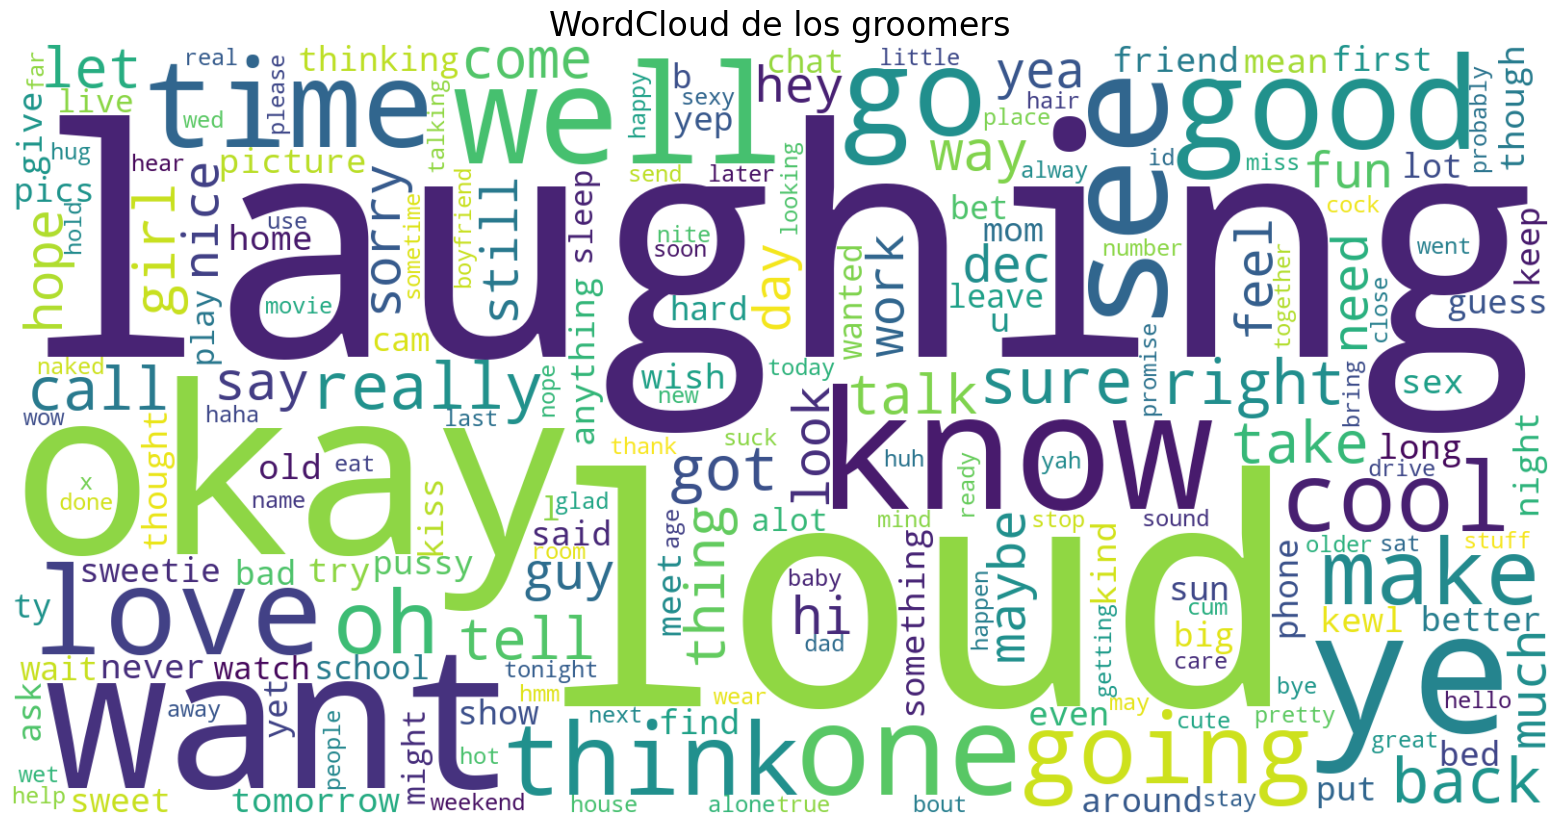

In [9]:
# Une todos los textos del cuerpo de los mensajes en una sola cadena
predator_text = ' '.join(combined_df[combined_df['role'] == 'predator']['normalized_body'].dropna().astype(str))

predator_text = predator_text.lower()

stop_words = set(stopwords.words('english'))

predator_text = re.sub(r'\d+', '', predator_text)
predator_text = re.sub(r'[^\w\s]', '', predator_text)

palabras = [word for word in predator_text.split() if word not in stop_words]

# Crea el objeto WordCloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate(' '.join(palabras))

# Mostrar el WordCloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de los groomers", fontsize=24)
plt.show()

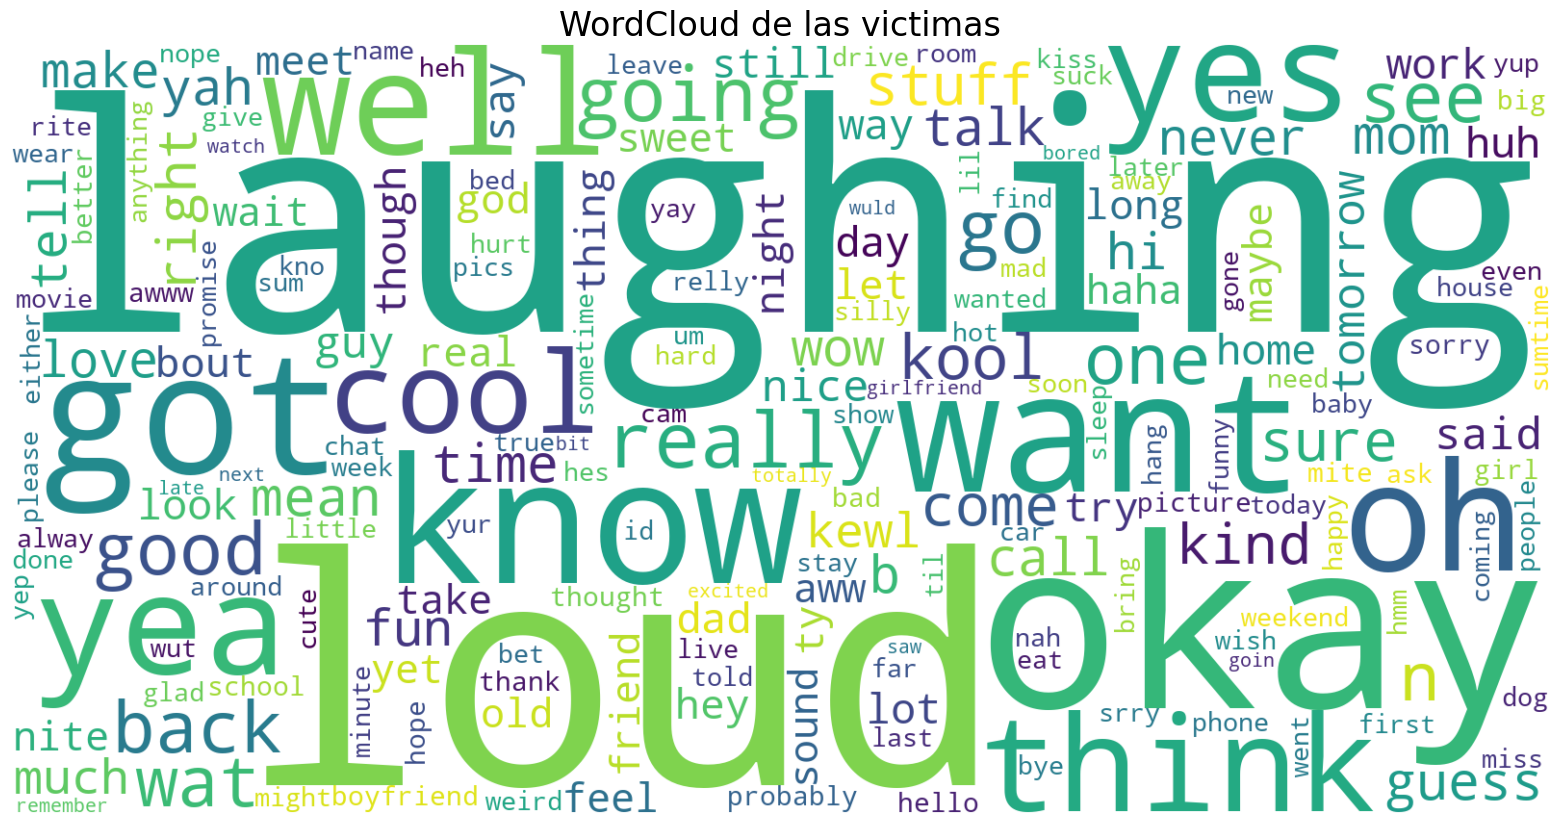

In [10]:

# Une todos los textos del cuerpo de los mensajes en una sola cadena
victim_text = ' '.join(combined_df[combined_df['role'] == 'victim']['normalized_body'].dropna().astype(str))

victim_text = victim_text.lower()

stop_words = set(stopwords.words('english'))

victim_text = re.sub(r'\d+', '', victim_text)
victim_text = re.sub(r'[^\w\s]', '', victim_text)

palabras = [word for word in victim_text.split() if word not in stop_words]

# Crea el objeto WordCloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate(' '.join(palabras))

# Mostrar el WordCloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de las victimas", fontsize=24)
plt.show()

Se ha visualizado varios "Slangs" que usan tanto los groomers como las victimas, por lo que se ha creado un diccionario para poder entender mejor las palabras usadas y pasarlas a palabras mas formales

 **Cantidad de mensajes de predadores y victimas en el archivo de ejemplo**

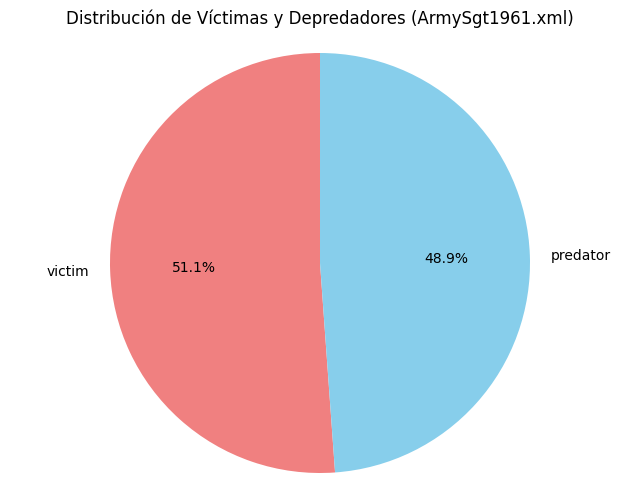

In [11]:
conteo = combined_df['role'].value_counts()

conteo = conteo[conteo.index.isin(['victim', 'predator'])]

plt.figure(figsize=(8, 6))
plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
plt.title('Distribución de Víctimas y Depredadores (ArmySgt1961.xml)')
plt.axis('equal')

plt.show()

Contador de la longitud de palabras en archivo *'ArmySgt1961.xml'*

In [12]:
combined_df['word_length'] = combined_df['normalized_body'].str.split().str.len()

# Mostrar las primeras filas para verificar
print(combined_df[['role', 'normalized_body', 'word_length']].head())


       role                              normalized_body  word_length
0  predator  i am dennis us army soldier from cincinnati            8
1    victim                        hi i am becky from ky            6
2  predator                              how old are you            4
3    victim                           13 how old are you            5
4  predator                                   you single            2


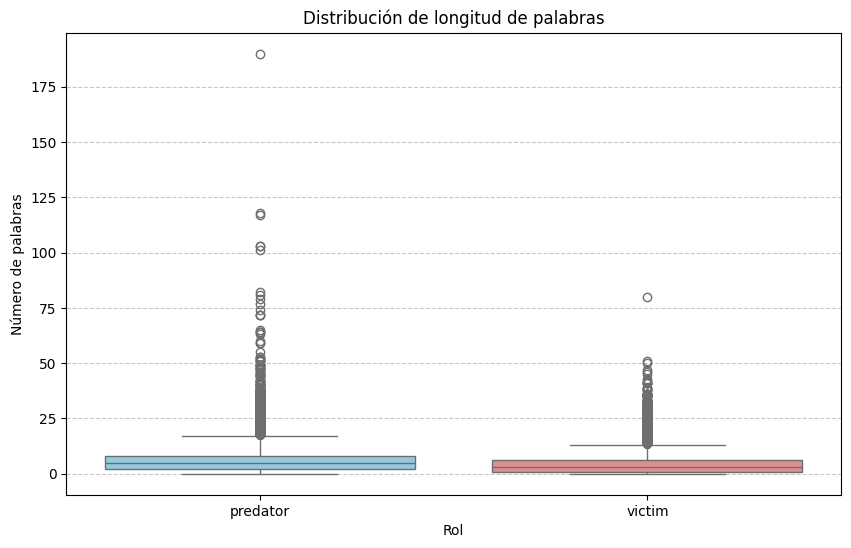

In [13]:
import seaborn as sns

# Filtrar datos
df_filtered = combined_df[combined_df['role'].isin(['victim', 'predator'])]

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='role',
    y='word_length',
    hue='role',  # <- Añadimos hue para evitar el warning
    data=df_filtered,
    palette={'victim': 'lightcoral', 'predator': 'skyblue'},
    legend=False  # <- Ocultamos leyenda si no es necesaria
)
plt.title('Distribución de longitud de palabras')
plt.xlabel('Rol')
plt.ylabel('Número de palabras')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
#plt.ylim(0, 20)   Mostrar solo mensajes con menos de 20 palabras

plt.show()

In [14]:
pd.set_option('display.max_colwidth', None)  # Desactiva el recorte
print(combined_df[combined_df['role'] == 'predator'].nlargest(1, 'word_length')['normalized_body'])


11476    hi love i have look too see if you came back on a few times i did not like how our talk ended that day i am wondering if i made you upset if i did i am very so sorry i am sorry that one guy hurt you and got you in trouble that one time from our chat that day i was thinking that i sounded like him and i am so so so sorry i totally understand and it hurts me so bad that what happen too you interfer your trust in me fully you are too good of a young women so nice i cannot do that too you i am sorry if i made you feel otherwise i worry about you hunny and i am sad because of this and too let you know i will wait that week of that weekend for that info okay i hope it b toward the beginning of the week i hope you do not think different about me i have something too show you on cam mon night i b on around 10 15 10 30 the regular
Name: normalized_body, dtype: object


In [15]:

#combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], errors='coerce')
dt_data = combined_df['datetime']

fecha_df = pd.DataFrame({'datetime_str': dt_data})

def preprocess_datetime(dt_str):

    if pd.isna(dt_str) or not isinstance(dt_str, str):
        return None

    #Sacar parentesis
    dt_str = dt_str.strip("()")

    #Sacar corchetes
    dt_str = dt_str.strip("[]")

    # Sacar espacios
    re.sub(r'\s+', ' ', dt_str).strip()

    # Estandarizar am/pm
    dt_str = dt_str.replace('a.m.', 'am').replace('p.m.', 'pm')
    dt_str = dt_str.replace('A.M.', 'AM').replace('P.M.', 'PM')

    if not dt_str:
        return None
    return dt_str

fecha_df['datetime_limpio'] = fecha_df['datetime_str'].apply(preprocess_datetime)
print(fecha_df[['datetime_str', 'datetime_limpio']].head(20))

    datetime_str datetime_limpio
0   (7:02:01 pm)      7:02:01 pm
1   (7:02:30 pm)      7:02:30 pm
2   (7:02:35 pm)      7:02:35 pm
3   (7:02:42 pm)      7:02:42 pm
4   (7:02:44 pm)      7:02:44 pm
5   (7:02:51 pm)      7:02:51 pm
6   (7:03:03 pm)      7:03:03 pm
7   (7:03:11 pm)      7:03:11 pm
8   (7:03:28 pm)      7:03:28 pm
9   (7:03:32 pm)      7:03:32 pm
10  (7:03:45 pm)      7:03:45 pm
11  (7:03:54 pm)      7:03:54 pm
12  (7:04:00 pm)      7:04:00 pm
13  (7:04:08 pm)      7:04:08 pm
14  (7:04:18 pm)      7:04:18 pm
15  (7:04:45 pm)      7:04:45 pm
16  (7:05:01 pm)      7:05:01 pm
17  (7:05:07 pm)      7:05:07 pm
18  (7:05:13 pm)      7:05:13 pm
19  (7:05:37 pm)      7:05:37 pm


In [16]:
# Formato fecha y hora
formats_to_try = [
    "%m/%d/%Y %I:%M:%S %p",  # ej, 5/12/2006 1:53:15 pm
    "%m/%d/%y %I:%M:%S %p",  # ej, 10/01/08 9:43:46 pm
    "%I:%M:%S %p",           # ej, 7:14:04 pm
    "%I:%M %p"
]
fecha_df['datetime_parseado'] = pd.NaT

for i, row in fecha_df.iterrows():
    val_limpio = row['datetime_limpio']
    if pd.isna(val_limpio):
        continue

    parseado = False
    for fmt in formats_to_try:
        try:
            fecha_df.loc[i, 'datetime_parseado'] = pd.to_datetime(val_limpio, format=fmt)
            parseado = True
            break
        except ValueError:
            continue

print(fecha_df[['datetime_str', 'datetime_limpio', 'datetime_parseado']].head(20))

unparsed = fecha_df[fecha_df['datetime_parseado'].isna() & fecha_df['datetime_limpio'].notna()]
if not unparsed.empty:
    print(f"\n {len(unparsed)} Entradas no pudieron ser parseadas:")
    print(unparsed[['datetime_str', 'datetime_limpio']])
    print("\nEntradas no parseadas:")
    print(unparsed['datetime_limpio'].value_counts())
else:
    print("\nEntradas datetime no nulas ya parseadas o limpias.")

    datetime_str datetime_limpio   datetime_parseado
0   (7:02:01 pm)      7:02:01 pm 1900-01-01 19:02:01
1   (7:02:30 pm)      7:02:30 pm 1900-01-01 19:02:30
2   (7:02:35 pm)      7:02:35 pm 1900-01-01 19:02:35
3   (7:02:42 pm)      7:02:42 pm 1900-01-01 19:02:42
4   (7:02:44 pm)      7:02:44 pm 1900-01-01 19:02:44
5   (7:02:51 pm)      7:02:51 pm 1900-01-01 19:02:51
6   (7:03:03 pm)      7:03:03 pm 1900-01-01 19:03:03
7   (7:03:11 pm)      7:03:11 pm 1900-01-01 19:03:11
8   (7:03:28 pm)      7:03:28 pm 1900-01-01 19:03:28
9   (7:03:32 pm)      7:03:32 pm 1900-01-01 19:03:32
10  (7:03:45 pm)      7:03:45 pm 1900-01-01 19:03:45
11  (7:03:54 pm)      7:03:54 pm 1900-01-01 19:03:54
12  (7:04:00 pm)      7:04:00 pm 1900-01-01 19:04:00
13  (7:04:08 pm)      7:04:08 pm 1900-01-01 19:04:08
14  (7:04:18 pm)      7:04:18 pm 1900-01-01 19:04:18
15  (7:04:45 pm)      7:04:45 pm 1900-01-01 19:04:45
16  (7:05:01 pm)      7:05:01 pm 1900-01-01 19:05:01
17  (7:05:07 pm)      7:05:07 pm 1900-01-01 19

C:\Users\javie\AppData\Local\Temp\ipykernel_7200\4024744203.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fecha_df_valid_dates['hora_del_dia'] = fecha_df_valid_dates['datetime_parseado'].dt.hour


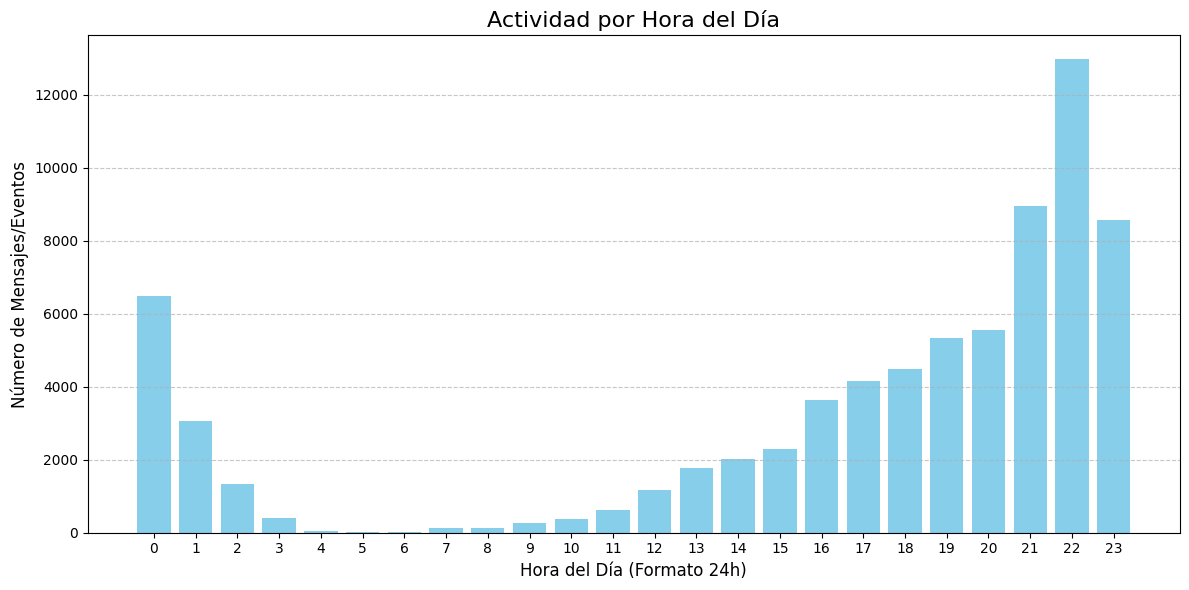


Tabla de actividad por hora del día:
hora_del_dia
0      6491
1      3069
2      1341
3       399
4        50
5        14
6        12
7       133
8       135
9       274
10      373
11      622
12     1178
13     1760
14     2015
15     2294
16     3635
17     4143
18     4493
19     5342
20     5563
21     8964
22    12977
23     8567
Name: count, dtype: int64


In [17]:
fecha_df['datetime_parseado'] = pd.to_datetime(fecha_df['datetime_parseado'], errors='coerce')

# Extraer la hora del dia
fecha_df_valid_dates = fecha_df.dropna(subset=['datetime_parseado'])
fecha_df_valid_dates['hora_del_dia'] = fecha_df_valid_dates['datetime_parseado'].dt.hour

# Contar la actividad por hora
actividad_por_hora = fecha_df_valid_dates['hora_del_dia'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(actividad_por_hora.index, actividad_por_hora.values, color='skyblue', width=0.8)

plt.title('Actividad por Hora del Día', fontsize=16)
plt.xlabel('Hora del Día (Formato 24h)', fontsize=12)
plt.ylabel('Número de Mensajes/Eventos', fontsize=12)
plt.xticks(ticks=range(0, 24), labels=[str(h) for h in range(0, 24)])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nTabla de actividad por hora del día:")
print(actividad_por_hora)

# Preparacion ML


In [18]:
chats_agrupados = combined_df.groupby('file')['normalized_body'].apply(lambda msgs : ' '.join(msgs)).reset_index()
chats_agrupados.columns = ['file','full_chat']
chats_agrupados['label'] = 1


In [19]:
grooming_chats_agrupados = chats_agrupados.drop(columns=['file'])

In [20]:
from datasets import load_dataset

dataset = load_dataset("daily_dialog", trust_remote_code=True)

c:\Users\javie\Desktop\Udec\SEMESTRE 7\Analisis de Datos\Entregas\Entrega3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
dialog_data = dataset['train'].to_pandas()

In [22]:
dialog_data['dialog'] = dialog_data['dialog'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) and x.startswith('[') else ' '.join(x) if isinstance(x,list) else str(x))
dialog_data['normalized_dialog'] = dialog_data['dialog'].apply(normalize_text)

In [23]:
dialog_data = dialog_data.drop(columns=['act'])
dialog_data = dialog_data.drop(columns=['emotion'])
dialog_data['label'] = 0

In [24]:
dialog_chats_agrupados = dialog_data[['normalized_dialog']].copy()
dialog_chats_agrupados.rename(columns={'normalized_dialog': 'full_chat'}, inplace=True)
dialog_chats_agrupados['label'] = 0


In [25]:
dialog_chats_agrupados

,full_chat,label
0,say jim how about going for a few beers after dinner you know that is tempting but is really not good for our fitness what do you mean it will help us to relax do you really think so i do not it will just make us fat and act silly remember last time i guess you are right but what shall we do i do not feel like sitting at home i suggest a walk over to the gym where we can play singsong and meet some of our friends that is a good idea i hear mary and sally often go there to play pingpong perhaps we can make a foursome with them sounds great to me if they are willing we could ask them to go dancing with us that is excellent exercise and fun too good let s go now all right,0
1,can you do push ups of course i can it is a piece of cake believe it or not i can do 30 push ups a minute really i think that is impossible you mean 30 push ups yes it is easy if you do exercise everyday you can make it too,0
2,can you study with the radio on no i listen to background music what is the difference the radio has too many comerials that is true but then you have to buy a record player,0
3,are you all right i will be all right soon i was terrified when i watched them fall from the wire do not worry he is an acrobat i see,0
4,hey john nice skates are they new yes i just got them i started playing ice hockey in a community league so i finally got myself new skates what position do you play i m a defender it s a lot of fun you don t have to be able to skate as fast on defense yes you re a pretty big guy i play goalie myself oh yes which team the rockets really i think we play you guys next week well i have to go to practice see you later all right see you later,0
...,...,...
11113,hello i bought a pen in your shop just before yes thank you very much now i came back to the hotel and try to show it to my friend the pen is broken i am afraid oh is it would you change it to a new one yes certainly you have the receipt yes i do then would you kindly come to our shop with the receipt by 10 of the clock we will replace it thank you so much,0
11114,do you have any seats available yes this way please what is the special today i recommend our new english pizza then give me a large one and an egg drop soup okay wait a minute please,0
11115,uncle ben how did the forbidden city get this name well in the feudal society emperors had supreme power so his residence was certainly a forbidden palace his residence you mean the whole palace yes the forbidden city is divided into two parts the southern section or the outer court was for the emperor to exercise his power over the nation and the northern part or the inner court was for his royal family oh unbelievable this was too luxurious even the whole country belonged to him that is why he is called the emperor okay then i love these unique structured towers with the delicate carvings on them it is really artistic yes the buildings and designs of the forbidden city are the peak of chinese traditional architecture not only scientific but also suitable for living i agree it is definitely a product of wisdom well why were those small animal sculptures placed on the tops of the buildings some of them are mascots and some are symbols of power why are there so many yellow things is yellow the lucky color in china oh no in fact yellow is the symbol of the royal family just like the pattern dragon right exactly here is the nine dragon screen oh it is really fabulous i want to take a picture here sure this will be a really good picture,0
11116,may i help you sir i want a pair of locus take a look at the ones on display please i need size 41,0


In [26]:
datos_para_ml = pd.concat([grooming_chats_agrupados, dialog_chats_agrupados], ignore_index=True)


In [27]:
output_filename = 'datos_finales_para_ml.csv'
try:
    datos_para_ml.to_csv(output_filename, index=False)
    print(f"\n DF final para ML guardado en: {output_filename}")
except Exception as e:
    print(f"Error al guardar el archivo: {e}")


 DF final para ML guardado en: datos_finales_para_ml.csv
